# NYC Restaurant Health Inspection Data Project

## This project analyzes New York City restaurant health inspection results. 

## Project Objective: (overview)


### There are 9 Steps in this project:
   ##### Step 1: Importing the data and understanding what is in the NYC health inspection csv file
   ##### Step 2: Data Cleaning - Score and Grade columns
   ##### Step 3: Data Cleaning - Borough column
   ##### Step 4: Grade distribution depending on Borough
   ##### Step 5: Grade distribution depending on cuisine
   ##### Step 6: Health inspection score distrubition  
   ##### Step 7: Critical or not critical restaurants and violations that cause them 
   ##### Step 8: Restaurants in danger of being permanently closed 
   ##### Step 9: Model to predict a critical or not critical evaluation

There are three parts that compose this project:
    Determining if there are trends with restaurant grade ratings due to the location of the restaurant (borough),the type of food, and ...... 
    Development of a model to try to determine if we can predict ....... 
    A closer look at the neighborhoods of Manhattan and their restaurant    

# Step 1
## Importing the data and understanding what is in the NYC health inspection csv file

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#importing the data
df = pd.read_csv('NYCdata.csv')

In [3]:
#understanding the data
df.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,41720461,LA COCINA DE ALEX,Queens,10203,JAMAICA AVENUE,11418.0,7188497509,Spanish,04/28/2018,Violations were cited in the following area(s).,...,02/05/2020,Cycle Inspection / Initial Inspection,40.695164,-73.845049,409.0,32.0,2600.0,4191641.0,4.091870e+09,QN54
1,50074496,CAFE BISTRO,Manhattan,312,W 34TH ST,10001.0,9172612450,American,07/31/2018,Violations were cited in the following area(s).,...,02/05/2020,Cycle Inspection / Initial Inspection,40.752458,-73.994138,104.0,3.0,10300.0,1013552.0,1.007570e+09,MN13


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400735 entries, 0 to 400734
Data columns (total 26 columns):
CAMIS                    400735 non-null int64
DBA                      400307 non-null object
BORO                     400735 non-null object
BUILDING                 400483 non-null object
STREET                   400734 non-null object
ZIPCODE                  395193 non-null float64
PHONE                    400719 non-null object
CUISINE DESCRIPTION      400735 non-null object
INSPECTION DATE          400735 non-null object
ACTION                   399189 non-null object
VIOLATION CODE           394852 non-null object
VIOLATION DESCRIPTION    391483 non-null object
CRITICAL FLAG            391483 non-null object
SCORE                    383588 non-null float64
GRADE                    202305 non-null object
GRADE DATE               200053 non-null object
RECORD DATE              400735 non-null object
INSPECTION TYPE          399189 non-null object
Latitude                

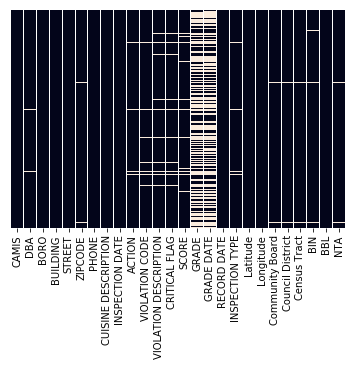

In [5]:
#Wanting to know the null (empty) spots in the dataset that we should be aware of
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

This heatmap shows the empty cells that are in the dataset. Empty cells need to be taken into account when deciding what data can we base our model off of and what assumptions have to be made. From this you can see that the restaurant grade data has multiple empty cells, so this most likely won't be a great area to get meaningful results for the whole dataset. On the other hand, you can see that the Score, which is what determines the restaurant grade has significantly less empty cells meaning this data would be better to use for making conclusions in the future. 

We could write some code to use the score value to fill in the empty cells for the restaurant grades, this will be looked at in Step ## of the project. 

# Step 2
## Data Cleaning - Score and Grade columns 
Removing the empty score columns (4% of the data), and filling in the empty grade columns (50%)

In [6]:
#number of empty cells in GRADE column
df['GRADE'].isnull().value_counts()

False    202305
True     198430
Name: GRADE, dtype: int64

In [7]:
#number of empty cells in SCORE column
df['SCORE'].isnull().value_counts()

False    383588
True      17147
Name: SCORE, dtype: int64

In [8]:
#about 4.3% of the score data is unknown, don't have a reasonable number to replace these empty spots 
#so these data points will be dropped
df_1 = df.dropna(subset=['SCORE'])

In [9]:
#function to use the Score to assign a grade when GRADE column cell is empty
#regulations say an A is 0-13, B is 13-27, C is anything above

def impute_grade(cols):
    GRADE = cols[0]
    SCORE = cols[1]
    
    if pd.isnull(GRADE):

        if SCORE > 27:
            return 'C'

        elif SCORE  <= 13:
            return 'A'

        else:
            return 'B'

    else:
        return GRADE

In [10]:
df_1['GRADE'].isnull().value_counts()

False    202294
True     181294
Name: GRADE, dtype: int64

In [11]:
#applying the function to our data to fill in empty grade cells and heatmap to check this
df_1.loc[:,'GRADE'] = df_1[['GRADE','SCORE']].apply(impute_grade,axis=1)

/Users/Brittney/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


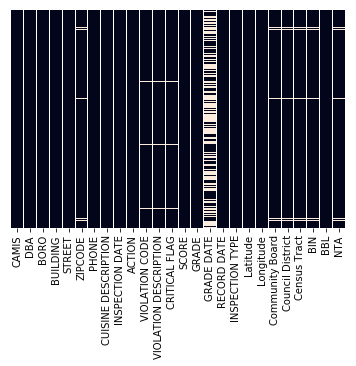

In [12]:
sns.heatmap(df_1.isnull(),yticklabels=False,cbar=False)

# Step 3
## Data cleaning - Borough column

In [13]:
#Confirming there are no empty cells in the BORO column, the heatmap shows there isn't
df_1['BORO'].isnull().value_counts()

False    383588
Name: BORO, dtype: int64

In [14]:
#Want to determine the number of restaurants in each borough. 
boro = df_1['BORO'].value_counts()
print(boro)

Manhattan        151007
Brooklyn          97159
Queens            87776
Bronx             34866
Staten Island     12704
0                    76
Name: BORO, dtype: int64


76 entries have 0 for the borough, we need to determine what borough these are in and make sure they get entered as the correct borough. To do this we will use the zipcodes. 

In [15]:
df_1[df_1['BORO']=='0']['ZIPCODE'].value_counts()

11249.0    57
10168.0    14
10285.0     5
Name: ZIPCODE, dtype: int64

The zipcodes for the 0 data are associated with these boroughs so will have to replace them

11249 - Brooklyn 

10168 and 10285 - Manhattan

In [16]:
#replacing the 0 boroughs with brooklyn and manhattan
df_1.loc[:,'BORO'] = np.where((df_1['ZIPCODE'] == 11249.0),'Brooklyn', df_1['BORO']) 
df_1.loc[:,'BORO'] = np.where((df_1['ZIPCODE'] == 10168.0)|(df_1['ZIPCODE'] == 10285.0),'Manhattan', df_1['BORO']) 

In [17]:
#checking the data frame again
df_1['BORO'].value_counts()

Manhattan        151026
Brooklyn          97216
Queens            87776
Bronx             34866
Staten Island     12704
Name: BORO, dtype: int64

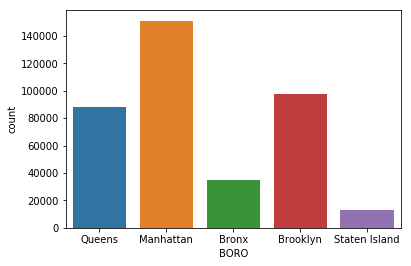

In [18]:
#plotting the data
sns.countplot(x='BORO', data = df_1)

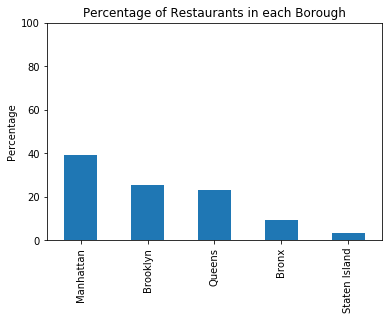

In [19]:
#plotting the data percent
boro_percent = df_1['BORO'].value_counts(normalize=True) * 100
boro_percent.plot.bar()

plt.ylim(0,100)
plt.title('Percentage of Restaurants in each Borough')
plt.ylabel('Percentage')
plt.show()

# Step 4 
## Grade distribution depending on borough

In [20]:
#only taking A, B, C inspection grades into account (not sure what P,N,G,Z mean but a small percentage of the data)
A_B_C_df = df_1[(df_1['GRADE'] == 'A')|(df_1['GRADE'].isin(['B','C']))]

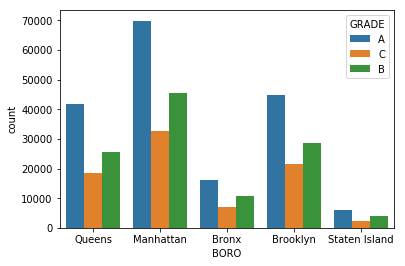

In [21]:
sns.countplot(x='BORO',hue='GRADE', data = A_B_C_df)

In [22]:
#percentage comparison to see if there is a bias by borough for grade, for a normalized comparison
queens_percent = A_B_C_df[A_B_C_df['BORO'] == 'Queens']['GRADE'].value_counts(normalize = True, dropna=False) *100
brooklyn_percent= A_B_C_df[A_B_C_df['BORO'] == 'Brooklyn']['GRADE'].value_counts(normalize = True, dropna=False) *100
manhattan_percent = A_B_C_df[A_B_C_df['BORO'] == 'Manhattan']['GRADE'].value_counts(normalize = True, dropna=False) *100
bronx_percent = A_B_C_df[A_B_C_df['BORO'] == 'Bronx']['GRADE'].value_counts(normalize = True, dropna=False) *100
staten_percent = A_B_C_df[A_B_C_df['BORO'] == 'Staten Island']['GRADE'].value_counts(normalize = True, dropna=False) *100

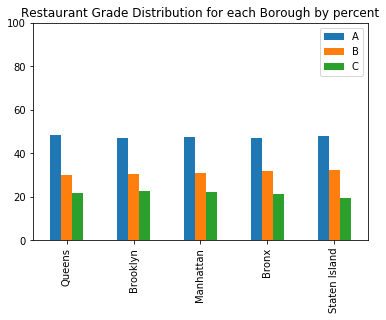

In [23]:
#plotting percentage bar graph
percent_combined = pd.DataFrame({'Queens': queens_percent, 'Brooklyn': brooklyn_percent, 'Manhattan':manhattan_percent,'Bronx':bronx_percent,'Staten Island':staten_percent})
transpose_percent_combined = percent_combined.transpose()

transpose_percent_combined.plot.bar()
plt.ylim(0,100)
plt.title('Restaurant Grade Distribution for each Borough by percent')
plt.show()

From the countplot you can see there is are significantly more restaurants in Manhattan and Queens compared to Staten Island. For comparing the boroughs to each other to see if there is a bias in health inspections or if one borough has significantly more A grades compared to C grades the data needs to be normalized. The normalized percentage distribution of A, B, C grades for each borough shows that each borough has a similar distributions, almost 50% A grades, 30% B grades, and 20% C grades. From this you can conclude there is no bias in health inspection ratings depending on the borough.

# Step 5
## Grade distribution depending on cuisine

In [24]:
print(df_1['CUISINE DESCRIPTION'].value_counts().head(10))

American                                                            80288
Chinese                                                             40915
Café/Coffee/Tea                                                     18693
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    16861
Pizza                                                               16820
Mexican                                                             15914
Italian                                                             15581
Japanese                                                            13998
Caribbean                                                           13778
Bakery                                                              12065
Name: CUISINE DESCRIPTION, dtype: int64


In [25]:
#organizing data into separate Cuisines, using the top 10 cuisines
American = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'American']['GRADE'].value_counts()
Chinese = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Chinese']['GRADE'].value_counts()
Cafe_Coffee_Tea = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Café/Coffee/Tea']['GRADE'].value_counts()
Latin = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)']['GRADE'].value_counts()
Pizza = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Pizza']['GRADE'].value_counts()
Mexican = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Mexican']['GRADE'].value_counts()
Italian = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Italian']['GRADE'].value_counts()
Caribbean = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Caribbean']['GRADE'].value_counts()
Japanese = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Japanese']['GRADE'].value_counts()
Spanish = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Spanish']['GRADE'].value_counts()

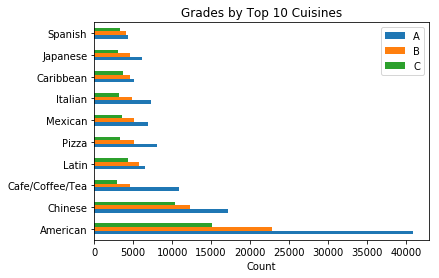

In [26]:
#combining the separated dataframes to make a bar graph comparing the inspection grades
grade_combo = pd.DataFrame({'American': American, 'Chinese': Chinese, 'Cafe/Coffee/Tea': Cafe_Coffee_Tea,'Latin': Latin,'Pizza':Pizza,'Mexican':Mexican,'Italian':Italian,'Caribbean':Caribbean, 'Japanese':Japanese,'Spanish': Spanish})
transpose_grade_combo = grade_combo.transpose()


transpose_grade_combo.plot.barh()
plt.title('Grades by Top 10 Cuisines')
plt.xlabel('Count')
plt.show()

In [27]:
#Converting from counts to percentages for a normalized comparison
American_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'American']['GRADE'].value_counts(normalize = True, dropna=False) *100
Chinese_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Chinese']['GRADE'].value_counts(normalize = True, dropna=False) *100
Cafe_Coffee_Tea_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Café/Coffee/Tea']['GRADE'].value_counts(normalize = True, dropna=False) *100
Latin_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)']['GRADE'].value_counts(normalize = True, dropna=False) *100
Pizza_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Pizza']['GRADE'].value_counts(normalize = True, dropna=False) *100
Mexican_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Mexican']['GRADE'].value_counts(normalize = True, dropna=False) *100
Italian_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Italian']['GRADE'].value_counts(normalize = True, dropna=False) *100
Caribbean_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Caribbean']['GRADE'].value_counts(normalize = True, dropna=False) *100
Japanese_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Japanese']['GRADE'].value_counts(normalize = True, dropna=False) *100
Spanish_p = A_B_C_df[A_B_C_df['CUISINE DESCRIPTION'] == 'Spanish']['GRADE'].value_counts(normalize = True, dropna=False) *100

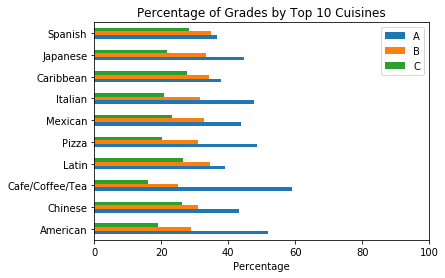

In [28]:
#plotting the percentage comparison
grade_combo_p = pd.DataFrame({'American': American_p, 'Chinese': Chinese_p, 'Cafe/Coffee/Tea': Cafe_Coffee_Tea_p,'Latin': Latin_p,'Pizza':Pizza_p,'Mexican':Mexican_p,'Italian':Italian_p,'Caribbean':Caribbean_p, 'Japanese':Japanese_p,'Spanish': Spanish_p})
transpose_grade_combo_p = grade_combo_p.transpose()


transpose_grade_combo_p.plot.barh()
plt.xlim(0,100)
plt.title('Percentage of Grades by Top 10 Cuisines')
plt.xlabel('Percentage')
plt.show()

When looking at the percentage of grades (the normalized data) for the top 10 cuisines, it shows that a Cafe/coffee/tea place is most likely to have an A health inspection score. This could be due to the fact that they do not do as much food handling or cooking so it is easier to keep the place up to health code standards compared to a restaurant. It is also shown that Spanish, Caribbean, and Latin food have the lowest percentage of A grades and the highest percentage of C grades. This means you are more likely to see a spanish, carribean, latin restaurant with a C grade compared to seeing a Cafe with a C grade. 

# Step 6

## Health inspection score distrubition  

In [29]:
A_score = df_1[df_1['SCORE'] <= 13]
B_score = df_1[(df_1['SCORE'] > 13) & (df_1['SCORE'] <=27 )]
C_score = df_1[df_1['SCORE'] > 27]

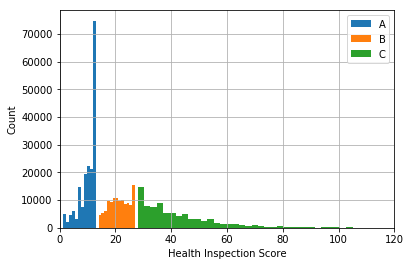

In [30]:
A_score['SCORE'].hist(bins=13)
B_score['SCORE'].hist(bins=13)
C_score['SCORE'].hist(bins=60)
plt.xlim(0,120)
plt.xlabel('Health Inspection Score')
plt.ylabel('Count')
plt.legend(['A','B','C'])
plt.show()

# Step 7

## Critical or not critical restaurants and violations that cause them 

In [31]:
#Understanding the Inspection type each restaurant was having
df_1['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                          233985
Cycle Inspection / Re-inspection                                96560
Pre-permit (Operational) / Initial Inspection                   28055
Pre-permit (Operational) / Re-inspection                        12307
Cycle Inspection / Reopening Inspection                          4486
Pre-permit (Non-operational) / Initial Inspection                3512
Pre-permit (Operational) / Compliance Inspection                 1281
Pre-permit (Operational) / Reopening Inspection                  1093
Inter-Agency Task Force / Initial Inspection                     1088
Cycle Inspection / Compliance Inspection                          725
Pre-permit (Non-operational) / Re-inspection                      347
Pre-permit (Operational) / Second Compliance Inspection           101
Pre-permit (Non-operational) / Compliance Inspection               32
Cycle Inspection / Second Compliance Inspection                    14
Pre-permit (Non-oper

In [32]:
#Understanding the Actions taken from the inspection
df_1['ACTION'].value_counts()

Violations were cited in the following area(s).                                                                                        361588
Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.     15239
Establishment re-opened by DOHMH                                                                                                         4373
No violations were recorded at the time of this inspection.                                                                              1263
Establishment re-closed by DOHMH                                                                                                         1125
Name: ACTION, dtype: int64

In [33]:
#Description of the various violations
df_1['VIOLATION DESCRIPTION'].value_counts()

Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.                      56880
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.                                                                                                                                                                   44633
Evidence of mice or live mice present in facility's food and/or non-food areas.                                                                                                                                                                                                                      29767
Food contact surface not properly washed, rinsed and sanitized after each use and following any activit

In [119]:
#dropping empty dataframes in the violations description
df_violation_description = df_1.dropna(subset=['VIOLATION DESCRIPTION'])

Mice = 29767
Roaches = 8895
Flies = 21341
Rats = 2716
Vermin = 44633
Other Violations = 273463
Total Dataset = 380815


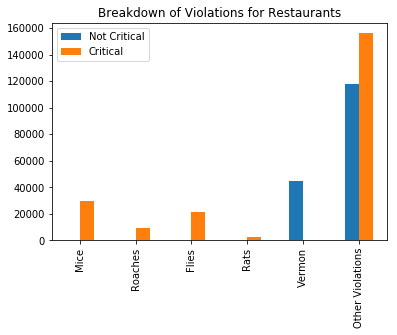

In [35]:
df_mice = df_violation_description[df_violation_description['VIOLATION DESCRIPTION'].str.contains('mice')]
df_roaches = df_violation_description[df_violation_description['VIOLATION DESCRIPTION'].str.contains('roaches')]
df_flies = df_violation_description[df_violation_description['VIOLATION DESCRIPTION'].str.contains('flies')]
df_rats= df_violation_description[df_violation_description['VIOLATION DESCRIPTION'].str.contains('rats')]
df_vermin = df_violation_description[df_violation_description['VIOLATION DESCRIPTION'].str.contains('vermin')]
df_other = df_violation_description[~df_violation_description['VIOLATION DESCRIPTION'].str.contains('vermin|mice|roaches|flies|rats')]

print('Mice = ' + str(len(df_mice)))
print('Roaches = ' + str(len(df_roaches)))
print('Flies = ' + str(len(df_flies)))
print('Rats = ' + str(len(df_rats)))
print('Vermin = ' + str(len(df_vermin)))
print('Other Violations = '+ str(len(df_other)))
print('Total Dataset = '+ str(len(df_violation_description)))

mice = df_mice['CRITICAL FLAG'].value_counts()
roaches = df_roaches['CRITICAL FLAG'].value_counts()
flies = df_flies['CRITICAL FLAG'].value_counts()
rats = df_rats['CRITICAL FLAG'].value_counts()
vermon = df_vermin['CRITICAL FLAG'].value_counts()
other = df_other['CRITICAL FLAG'].value_counts()

combined = pd.DataFrame({'Mice': mice, 'Roaches':roaches, 'Flies':flies,'Rats':rats,'Vermon':vermon ,'Other Violations':other})
transpose_combined = combined.transpose()

transpose_combined.plot.bar()
plt.title('Breakdown of Violations for Restaurants')
plt.legend(['Not Critical','Critical'])
plt.show()



# Step 8 

## Restaurants in danger of being permanently closed 

### Mostly due to rodent or vermin problems
### These restaurants have been re-closed in a cycle reinspection
### This means they when they were last inspected, they failed and had to close. This dataset is their second inspection in an attempt to reopen and they failed again. 

Mice = 175
Roaches = 81
Flies = 57
Rats = 18
Vermin = 242
Other = 209
Total Dataset = 782


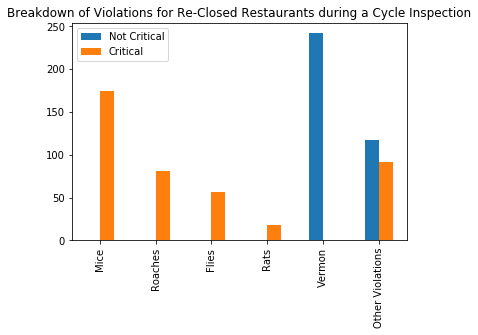

In [36]:
#Restaurants in danger of closing that have rodent problems
#meaning being re-closed on a cycle reinspection, meaning they failed again and can't reopen

#finding these restaurants
df_violation = df_violation_description[(df_violation_description['ACTION']=='Establishment re-closed by DOHMH') & (df_violation_description['INSPECTION TYPE']=='Cycle Inspection / Reopening Inspection')]

#dividing the restaurants depending on their violation
df_reclosed_mice = df_violation[df_violation['VIOLATION DESCRIPTION'].str.contains('mice')]
df_reclosed_roaches = df_violation[df_violation['VIOLATION DESCRIPTION'].str.contains('roaches')]
df_reclosed_flies = df_violation[df_violation['VIOLATION DESCRIPTION'].str.contains('flies')]
df_reclosed_rats = df_violation[df_violation['VIOLATION DESCRIPTION'].str.contains('rats')]
df_reclosed_vermin = df_violation[df_violation['VIOLATION DESCRIPTION'].str.contains('vermin')]
#Making a "Other" set showing the restaurants in this closure data that don't have these pest issues
df_reclosed_other = df_violation[~df_violation['VIOLATION DESCRIPTION'].str.contains('vermin|mice|roaches|flies|rats')]

#Determining the length of each dataframe
print('Mice = ' + str(len(df_reclosed_mice)))
print('Roaches = ' + str(len(df_reclosed_roaches)))
print('Flies = ' + str(len(df_reclosed_flies)))
print('Rats = ' + str(len(df_reclosed_rats)))
print('Vermin = ' + str(len(df_reclosed_vermin)))
print('Other = ' + str(len(df_reclosed_other)))
print('Total Dataset = '+ str(len(df_violation)))

#Finding which violations are critical Y/N in each new dataframe
reclosed_mice = df_reclosed_mice['CRITICAL FLAG'].value_counts()
reclosed_roaches = df_reclosed_roaches['CRITICAL FLAG'].value_counts()
reclosed_flies = df_reclosed_flies['CRITICAL FLAG'].value_counts()
reclosed_rats = df_reclosed_rats['CRITICAL FLAG'].value_counts()
reclosed_vermon = df_reclosed_vermin['CRITICAL FLAG'].value_counts()
reclosed_other = df_reclosed_other['CRITICAL FLAG'].value_counts()

#Combining this data into one dataframe to make a bar plot
reclosed_combined = pd.DataFrame({'Mice': reclosed_mice, 'Roaches':reclosed_roaches, 'Flies':reclosed_flies,'Rats':reclosed_rats,'Vermon':reclosed_vermon ,'Other Violations':reclosed_other})
transpose_reclosed_combined = reclosed_combined.transpose()

#Making a bar plot of this data
transpose_reclosed_combined.plot.bar()
plt.title('Breakdown of Violations for Re-Closed Restaurants during a Cycle Inspection')
plt.legend(['Not Critical','Critical'])
plt.show()


A high percentage of these restaurants have a critical score with rodent/vermin issues showing we can conclude that these violations warrant for a restaurant closure and need to be fixed in order for a place to reopen

## Plotting these restaurants on a map of Manhattan

In [57]:
#Redoing what was done above, just cleaner and adding the 'reason' column to the dataframe
df_violation.loc[:,'reason'] =pd.np.where(df_violation['VIOLATION DESCRIPTION'].str.contains('mice'), 'mice',
                            pd.np.where(df_violation['VIOLATION DESCRIPTION'].str.contains('roaches'), 'roaches',
                          pd.np.where(df_violation['VIOLATION DESCRIPTION'].str.contains('flies'), 'flies',
                          pd.np.where(df_violation['VIOLATION DESCRIPTION'].str.contains('rats'), 'rats',
                          pd.np.where(df_violation['VIOLATION DESCRIPTION'].str.contains('vermin'), 'vermin','other')))))


In [58]:
df_violation['reason'].value_counts()

vermin     242
other      209
mice       175
roaches     81
flies       57
rats        18
Name: reason, dtype: int64

In [108]:
#importing the libraries for doing a geographical plot
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
from pyproj import CRS

In [114]:
#importing the manhattan map that the data will be plotted on
street_map = gpd.read_file('/Users/Brittney/Desktop/sh/nyu_2451_34522.shp')
#fig,ax = plt.subplots(figsize = (8,8))
#street_map.plot(ax = ax)
#plt.show()

In [115]:
#only want the closed restaurants that are in manhattan
df_violation_manhattan = df_violation[df_violation['BORO']=='Manhattan']
df_violation_manhattan['CRITICAL FLAG'].value_counts()

Y    150
N    114
Name: CRITICAL FLAG, dtype: int64

In [116]:
# Defining the coordinate system
# Converting the latitude and longitude values to x,y (geometry) data points to be graphed
crs = CRS("epsg:4326")
geometry = [Point(xy) for xy in zip(df_violation_manhattan['Longitude'], df_violation_manhattan['Latitude'])]
geometry[:3]

In [117]:
#combining the data, the coordinate system, the geometry points 
geo_df = gpd.GeoDataFrame(df_violation_manhattan, crs=crs, geometry = geometry)

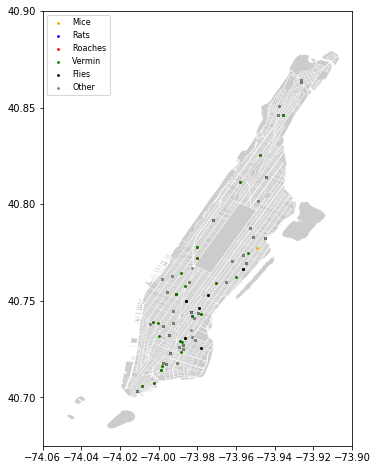

In [118]:
#Plotting the data on the map and labeling each data point

fig,ax = plt.subplots(figsize = (8,8))
street_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['reason'] == 'mice'].plot(ax=ax, markersize=3, color = 'orange', marker = 'o', label = 'Mice')
geo_df[geo_df['reason'] == 'rats'].plot(ax=ax, markersize=3, color = 'blue', marker = 'o', label = 'Rats')
geo_df[geo_df['reason'] == 'roaches'].plot(ax=ax, markersize=3, color = 'red', marker = 'o', label = 'Roaches')
geo_df[geo_df['reason'] == 'vermin'].plot(ax=ax, markersize=3, color = 'green', marker = 'o', label = 'Vermin')
geo_df[geo_df['reason'] == 'flies'].plot(ax=ax, markersize=3, color = 'black', marker = 'o', label = 'Flies')
geo_df[geo_df['reason'] == 'other'].plot(ax=ax, markersize=3, color = 'grey', marker = 'o', label = 'Other')

plt.legend(prop={'size':8})
plt.xlim(-74.06,-73.9)
plt.ylim(40.675,40.9)
plt.show()

# Step 9

## Model to predict a critical or not critical evaluation
   
We can use the score, restaurant grade, and critical flag to make a model for this data. 

maybe want to know if there is a correlation with critical flag and score or restaurant grade since I can not see this by looking at the data. Some A grades have a critical flag and some C grades don't have a critical flag. Not really sure what consitutes as a critical flag, maybe it is dependend on the type of violation code the restaurant recieves.

Using A_B_C_df data since it has the three letter grades we are interested in

(what about violation code????)

### not sure yet what we are predicting and what model to use, but need to make the data model ready

In [ ]:
#for this model if we want to use the critical flag data 
#Clean up the empty cells in the critical flag column
A_B_C_df['CRITICAL FLAG'].isnull().value_counts()

The empty data for Critical Flag is about 0.7%, I am just going to drop this data since I cannot see a correlation between Critical Flag, Score, or Restaurant grade rating. 

In [ ]:
#dropping empty values of critical flag data
df_2 = A_B_C_df.dropna(subset=['CRITICAL FLAG'])
sns.heatmap(df_2.isnull(),yticklabels=False,cbar=False)

In [ ]:
#function to convert the critcal flag Y/N to 1/0 to be used in developing a model
def converter(critical):
    if critical=='Y':
        return 1
    else:
        return 0

In [ ]:
#converting the critical flag column to 1/0 to the critical column
df_2.loc[:,'critical'] = df_2['CRITICAL FLAG'].apply(converter)

In [ ]:
#checking new data frame
df_2.info()

## Model 1 
## Critical or not based on SCORE

In [ ]:
#dropping non-numerical data columns from the model
df_model_1 = df_2.drop(['VIOLATION CODE','ACTION','GRADE','INSPECTION TYPE','Latitude','Longitude','CRITICAL FLAG','ZIPCODE','CAMIS','DBA','BORO','BUILDING','STREET','PHONE','CUISINE DESCRIPTION','INSPECTION DATE', 'VIOLATION DESCRIPTION','GRADE DATE', 'RECORD DATE','Council District','Census Tract','BIN','BBL','NTA','Community Board'], axis =1)

In [ ]:
# Data frame used for the model 
# Using the Score to predict critical Y/N
df_model_1.info()

In [ ]:
df_model_1.head()

In [ ]:
# Splitting the data into the training and testing set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_model_1.drop('critical',axis=1), 
                                                    df_model_1['critical'], test_size=0.30, 
                                                    random_state=101)

In [ ]:
# Training and fitting the Logisitic Regression Model to the data
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='lbfgs')
logmodel.fit(X_train,y_train)

In [ ]:
# The predictions and evaluation of the model 
predictions = logmodel.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

print(accuracy_score(y_test,predictions))

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

## Model 2

## Critical or Not based on SCORE and VIOLATION CODE

In [ ]:
#dropping non-numerical data columns from the model
df_model_2 = df_2.drop(['Latitude','Longitude','ACTION','GRADE','INSPECTION TYPE','CAMIS','CRITICAL FLAG','ZIPCODE','DBA','BORO','BUILDING','STREET','PHONE','CUISINE DESCRIPTION','INSPECTION DATE', 'VIOLATION DESCRIPTION','GRADE DATE', 'RECORD DATE','Council District','Census Tract','BIN','BBL','NTA','Community Board'], axis =1)

In [ ]:
# Data frame used for Model 2 
# Using the Score to predict critical Y/N
df_model_2.info()

In [ ]:
#Converting violation codes into 0,1 to be used in the machine learning model
violation_code =['VIOLATION CODE']
model_2 = pd.get_dummies(df_model_2,columns=violation_code,drop_first=True)
model_2.head()

In [ ]:
# Splitting the data into the training and testing set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(model_2.drop('critical',axis=1), 
                                                    model_2['critical'], test_size=0.30, 
                                                    random_state=101)

In [ ]:
# Training and fitting the Logisitic Regression Model to the data
from sklearn.linear_model import LogisticRegression

logmodel_2 = LogisticRegression(solver='lbfgs', max_iter=1000)
logmodel_2.fit(X_train,y_train)

In [ ]:
# The predictions and evaluation of the model 

predictions_2 = logmodel_2.predict(X_test)

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

print(accuracy_score(y_test,predictions_2))
print(classification_report(y_test,predictions_2))
print(confusion_matrix(y_test,predictions_2))